In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Overview

In this notebook, you'll learn how to submit a job to AI Platform Training. In the job you'll train your TensorFlow 2 model and export the saved model to Cloud Storage.

### Dataset

[CTA - Ridership - Daily Boarding Totals](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97): This dataset shows systemwide boardings for both bus and rail services provided by Chicago Transit Authority, dating back to 2001.

### Objective

The goal is to forecast future transit ridership in the City of Chicago, based on previous ridership.

## Install packages and dependencies

### Import libraries and define constants

In [2]:
import datetime
import googleapiclient.discovery
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf

from google.api_core.client_options import ClientOptions
from google.cloud import storage
from sklearn.preprocessing import StandardScaler

In [3]:
# Check the TensorFlow version installed

tf.__version__

'2.4.1'

In [4]:
# Enter your project, region, and a bucket name. Then run the  cell to make sure the
# Cloud SDK uses the right project for all the commands in this notebook.

REGION = 'us-west1-b' # REPLACE WITH YOUR REGION e.g. us-central1
PROJECT = 'summer-reef-305107' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'summer-reef-305107-lcm' # REPLACE WITH A UNIQUE BUCKET NAME e.g. your PROJECT NAME
BUCKET_URI = 'gs://' + BUCKET

#Don't change the following command - this is to check if you have changed the project name above.
assert PROJECT != 'your-project-name', 'Don''t forget to change the project variables!'

In [5]:
# Dataset parameters

target_col = 'total_rides' # The variable you are predicting
ts_col = 'service_date' # The name of the column with the date field

In [6]:
# Model parameters

freq = 'D' # Daily frequency
n_input_steps = 30 # Lookback window
n_output_steps = 7 # How many steps to predict forward
n_seasons = 7 # Monthly periodicity

train_split = 0.8 # % Split between train/test data
epochs = 1000 # How many passes through the data (early-stopping will cause training to stop before this)
patience = 5 # Terminate training after the validation loss does not decrease after this many epochs

lstm_units = 64
input_layer_name = 'lstm_input'

In [7]:
# Training parameters

MODEL_NAME = 'cta_ridership'
FRAMEWORK='TENSORFLOW'
RUNTIME_VERSION = '2.3'
PYTHON_VERSION = '3.7'
PREDICTIONS_FILE = 'predictions.json'

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model version based on this output in order to serve
online predictions.

In [8]:
storage_client = storage.Client()
try:
    bucket = storage_client.get_bucket(BUCKET)
    print('Bucket exists, let''s not recreate it.')
except:
    bucket = storage_client.create_bucket(BUCKET)
    print('Created bucket: ' + BUCKET)

Bucket exists, lets not recreate it.


## Load and preview the data

Pre-processing on the original dataset has been done for you and made available on Cloud Storage.

In [9]:
processed_file = 'cta_ridership.csv' # Which file to save the results to

if os.path.exists(processed_file):
    input_file = processed_file # File created in previous lab
else:
    input_file = f'data/{processed_file}'

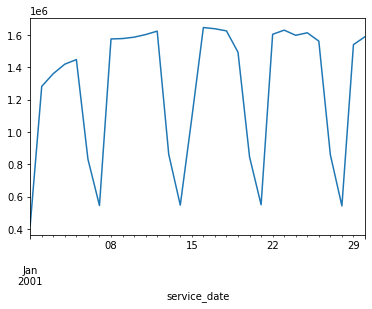

In [10]:
df = pd.read_csv(input_file, index_col=ts_col, parse_dates=True)

# Plot 30 days of ridership 
_ = df[target_col][:30].plot()

In [11]:
# Define some characteristics of the data that will be used later
n_features = len(df.columns)

# Index of target column. Used later when creating dataframes.
target_col_num = df.columns.get_loc(target_col)

### Process data

In [12]:
# Split data

size = int(len(df) * train_split)
df_train, df_test = df[0:size].copy(deep=True), df[size:len(df)].copy(deep=True)

df_train.head()

,total_rides
service_date,
2001-01-01,423647
2001-01-02,1282779
2001-01-03,1361355
2001-01-04,1420032
2001-01-05,1448343


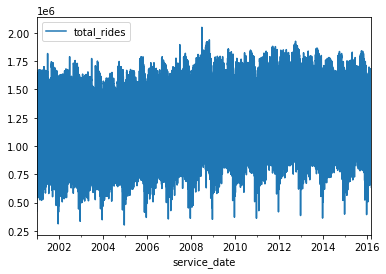

In [13]:
_ = df_train.plot()

### Scale values

In [14]:
# Review original values

df_train.head()

,total_rides
service_date,
2001-01-01,423647
2001-01-02,1282779
2001-01-03,1361355
2001-01-04,1420032
2001-01-05,1448343


In [15]:
# For neural networks to converge quicker, it is helpful to scale the values.
# For example, each feature might be transformed to have a mean of 0 and std. dev. of 1.
#
# You are working with a mix of features, input timesteps, output horizon, etc.
# which don't work out-of-the-box with common scaling utilities.
# So, here are a couple wrappers to handle scaling and inverting the scaling.

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

def scale(df, 
          fit=True, 
          target_col=target_col,
          feature_scaler=feature_scaler,
          target_scaler=target_scaler):
    """
    Scale the input features, using a separate scaler for the target.
    
    Parameters: 
    df (pd.DataFrame): Input dataframe
    fit (bool): Whether to fit the scaler to the data (only apply to training data)
    target_col (pd.Series): The column that is being predicted
    feature_scaler (StandardScaler): Scaler used for features
    target_scaler (StandardScaler): Scaler used for target
      
    Returns: 
    df_scaled (pd.DataFrame): Scaled dataframe   
    """    
    
    target = df[target_col].values.reshape(-1, 1)
    if fit:
        target_scaler.fit(target)
    target_scaled = target_scaler.transform(target)
    
    # Select all columns other than target to be features
    features = df.loc[:, df.columns != target_col].values
    
    if features.shape[1]:  # If there are any features
        if fit:
            feature_scaler.fit(features)
        features_scaled = feature_scaler.transform(features)
        
        # Combine target and features into one data frame
        df_scaled = pd.DataFrame(features_scaled)
        target_col_num = df.columns.get_loc(target_col)
        df_scaled.insert(target_col_num, target_col, target_scaled)
        df_scaled.columns = df.columns        
    
    else:  # If only target column (no additional features)
        df_scaled = pd.DataFrame(target_scaled, columns=df.columns)
      
    return df_scaled

def inverse_scale(data, target_scaler=target_scaler):
    """
    Transform the scaled values of the target back into their original form.
    The features are left alone, as we're assuming that the output of the model only includes the target.
    
    Parameters: 
    data (np.array): Input array
    target_scaler (StandardScaler): Scaler used for target
      
    Returns: 
    data_scaled (np.array): Scaled array   
    """    
    
    df = pd.DataFrame()
    data_scaled = np.empty([data.shape[1], data.shape[0]])
    for i in range(data.shape[1]):
        data_scaled[i] = target_scaler.inverse_transform(data[:,i])
    return data_scaled.transpose()

df_train_scaled=scale(df_train)
df_test_scaled=scale(df_test, False)

In [16]:
# Review scaled values

df_train_scaled.head()

,total_rides
0,-2.442494
1,-0.262138
2,-0.062724
3,0.086190
4,0.158040


### Create sequences of time series data

In [17]:
def reframe(data, n_input_steps = n_input_steps, n_output_steps = n_output_steps, target_col = target_col):

    target_col_num = data.columns.get_loc(target_col)    
    
    # Iterate through data and create sequences of features and outputs
    df = pd.DataFrame(data)
    cols=list()
    for i in range(n_input_steps, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_output_steps):
        cols.append(df.shift(-i))
        
    # Concatenate values and remove any missing values
    df = pd.concat(cols, axis=1)
    df.dropna(inplace=True)
    
    # Split the data into feature and target variables
    n_feature_cols = n_input_steps * n_features
    features = df.iloc[:,0:n_feature_cols]
    target_cols = [i for i in range(n_feature_cols + target_col_num, n_feature_cols + n_output_steps * n_features, n_features)]
    targets = df.iloc[:,target_cols]

    return (features, targets)

X_train_reframed, y_train_reframed = reframe(df_train_scaled)
X_test_reframed, y_test_reframed = reframe(df_test_scaled)

## Build a model and submit your training job to AI Platform

The model you're building here trains pretty fast so you could train it in this notebook, but for more computationally expensive models, it's useful to train them in the Cloud. To use AI Platform Training, you'll package up your training code and submit a training job to the AI Platform Prediction service.

In your training script, you'll also export your trained `SavedModel` to a Cloud Storage bucket.

### Prepare test data

In [18]:
# Reshape test data to match model inputs and outputs

X_train = X_train_reframed.values.reshape(-1, n_input_steps, n_features)
X_test = X_test_reframed.values.reshape(-1, n_input_steps, n_features)
y_train = y_train_reframed.values.reshape(-1, n_output_steps)
y_test = y_test_reframed.values.reshape(-1, n_output_steps)

In [19]:
# Specify directories to be used later

TRAINER_DIR = 'trainer'
EXPORT_DIR = 'tf_export'

In [20]:
# Create trainer directory if it doesn't already exist

!mkdir $TRAINER_DIR
!touch $TRAINER_DIR/__init__.py

In [21]:
# Copy numpy arrays to npy files

np.save(TRAINER_DIR + '/x_train.npy', X_train)
np.save(TRAINER_DIR + '/x_test.npy', X_test)
np.save(TRAINER_DIR + '/y_train.npy', y_train)
np.save(TRAINER_DIR + '/y_test.npy', y_test)

### Prepare model code

In [22]:
# Write training code out to a file that will be submitted to the training job
# Note: f-strings are supported in Python 3.6 and above

model_template = f"""import argparse
import numpy as np
import os
import tempfile

from google.cloud import storage
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

n_features = {n_features} # Two features: y (previous values) and whether the date is a holiday
n_input_steps = {n_input_steps} # Lookback window
n_output_steps = {n_output_steps} # How many steps to predict forward

epochs = {epochs} # How many passes through the data (early-stopping will cause training to stop before this)
patience = {patience} # Terminate training after the validation loss does not decrease after this many epochs

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--job-dir',
        default=None,
        help='URL to store the job output')
    args = parser.parse_args()
    print(args)
    return args

def main():
    args = get_args()
    print('args: ', args)
    model_dir = args.job_dir
    
    storage_client = storage.Client()
    bucket_name = model_dir.split('/')[2]
    
    bucket = storage_client.get_bucket(bucket_name)

    # Get the training data and convert back to np arrays
    local_data_dir = os.path.join(os.getcwd(), tempfile.gettempdir())
    
    data_files = ['x_train.npy', 'y_train.npy', 'x_test.npy', 'y_test.npy']
 
    for i in data_files:
        blob = storage.Blob('{TRAINER_DIR}/' + i, bucket)
        destination_file = local_data_dir + '/' + i
        open(destination_file, 'a').close()
        blob.download_to_filename(destination_file)

    X_train = np.load(local_data_dir + '/x_train.npy')
    y_train = np.load(local_data_dir + '/y_train.npy')
    X_test = np.load(local_data_dir + '/x_test.npy')
    y_test = np.load(local_data_dir + '/y_test.npy')
    
    # Build and train the model
    model = Sequential([
        LSTM({lstm_units}, input_shape=[n_input_steps, n_features], recurrent_activation=None),
        Dense(n_output_steps)])

    model.compile(optimizer='adam', loss='mae')

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
    _ = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])
    
    # Export the model
    export_path = os.path.join(model_dir, '{EXPORT_DIR}')
    model.save(export_path)
    
if __name__ == '__main__':
    main()
"""

with open(os.path.join(TRAINER_DIR, 'model.py'), 'w') as f:
    f.write(model_template.format(**globals()))

In [23]:
# Copy the model and training data files to a GCS bucket

!gsutil -m cp -r trainer $BUCKET_URI

Copying file://trainer/y_train.npy [Content-Type=application/octet-stream]...
Copying file://trainer/y_test.npy [Content-Type=application/octet-stream]...
Copying file://trainer/model.py [Content-Type=text/x-python]...                 
Copying file://trainer/__init__.py [Content-Type=text/x-python]...              
Copying file://trainer/x_test.npy [Content-Type=application/octet-stream]...    
Copying file://trainer/x_train.npy [Content-Type=application/octet-stream]...   
/ [6/6 files][  1.9 MiB/  1.9 MiB] 100% Done                                    
Operation completed over 6 objects/1.9 MiB.                                      


In [24]:
# List the contents of the bucket to ensure they were copied properly

!gsutil ls $BUCKET_URI/$TRAINER_DIR

gs://summer-reef-305107-lcm/trainer/__init__.py
gs://summer-reef-305107-lcm/trainer/model.py
gs://summer-reef-305107-lcm/trainer/x_test.npy
gs://summer-reef-305107-lcm/trainer/x_train.npy
gs://summer-reef-305107-lcm/trainer/y_test.npy
gs://summer-reef-305107-lcm/trainer/y_train.npy


### Submit training job

In [25]:
# Re-run this if you need to create a new training job

timestamp = str(datetime.datetime.now().time())
JOB_NAME = 'caip_training_' + str(int(time.time()))

In [26]:
# Set training job parameters

MODULE_NAME = TRAINER_DIR + '.model'
TRAIN_DIR = os.getcwd() + '/' + TRAINER_DIR
JOB_DIR = BUCKET_URI

In [ ]:
# Submit the training job

!gcloud ai-platform jobs submit training $JOB_NAME \
        --scale-tier basic \
        --package-path $TRAIN_DIR \
        --module-name $MODULE_NAME \
        --job-dir $BUCKET_URI \
        --region $REGION \
        --runtime-version $RUNTIME_VERSION \
        --python-version $PYTHON_VERSION

API [ml.googleapis.com] not enabled on project [795705120616]. Would 
you like to enable and retry (this will take a few minutes)? (y/N)?  

In [ ]:
# Check the job status

!gcloud ai-platform jobs describe $JOB_NAME

## Monitor output of your training job

Follow the instructions in the output of the gcloud command above to view the logs from your training job. You can also navigate to the [Jobs Section](https://console.cloud.google.com/ai-platform/jobs) of your Cloud Console to view logs.

Once your training job completes successfully, it'll export your trained model as a TensorFlow `SavedModel` and write the output to a directory in your Cloud Storage bucket.

In [ ]:
# Verify model was exported correctly

storage_client = storage.Client()
bucket = storage_client.get_bucket(BUCKET)
bucket_files = list(bucket.list_blobs(prefix=EXPORT_DIR + '/'))

# If you see a saved_model.pb and a variables/ and assets/ directory here, it means your model was exported correctly in your training job. Yay!

for file in bucket_files:
    print(file)

## Deploy a model version

In [ ]:
# Create model if it doesn't already exist

!gcloud ai-platform models create $MODEL_NAME --regions $REGION

In [ ]:
# Create the model version

export_path = BUCKET_URI +'/' + EXPORT_DIR
version = 'version_' + str(int(time.time()))

!gcloud ai-platform versions create $version \
  --model $MODEL_NAME \
  --origin $export_path \
  --runtime-version=$RUNTIME_VERSION \
  --framework $FRAMEWORK \
  --python-version=$PYTHON_VERSION

## Get predictions on deployed model

In [ ]:
# Initialize client

endpoint = f'https://ml.googleapis.com'
client_options = ClientOptions(api_endpoint=endpoint)
service = googleapiclient.discovery.build('ml', 'v1', client_options=client_options, cache_discovery=False)

In [ ]:
# Helper function to invoke the prediction service from
# https://github.com/GoogleCloudPlatform/python-docs-samples/blob/master/ml_engine/online_prediction/predict.py

def predict_json(project, model, instances, version=None):
    """Send json data to a deployed model for prediction.
    Args:
        project (str): project where the AI Platform Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """

    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [ ]:
# Predict with the 1st element from the test set

prediction_json = {input_layer_name: X_test[0].tolist()}

pred_val = predict_json(PROJECT, MODEL_NAME, prediction_json)

pred_val

In [ ]:
# Print prediction and compare to actual value

print('Predicted riders:', int(round(inverse_scale(np.array([pred_val[0]['dense'][0]]).reshape(1,1))[0][0])))
print('Actual riders:   ', int(round(inverse_scale(np.array([y_test[0]]))[0][0])))

## Cleanup

In [ ]:
# Delete model version resource
!echo gcloud ai-platform versions delete {version} --model {MODEL_NAME} --quiet 

# Delete model resource
!echo gcloud ai-platform models delete {MODEL_NAME} --quiet

## Conclusion

In this section, you've learned how to:
* Prepare data and models for training in the cloud
* Train your model and monitor the progress of the job with AI Platform Training
* Predict using the model with AI Platform Predictions